This notebook is inspired by the tutorial from this web page:
https://www.datacamp.com/community/tutorials/tensorflow-tutorial#basics

In [1]:
import tensorflow as tf

x1 = tf.constant(2)
x2 = tf.constant(3)

result1 = tf.multiply(x1,x2)
result2 = tf.add(x1,x2)
print(result1,result2)

Tensor("Mul:0", shape=(), dtype=int32) Tensor("Add:0", shape=(), dtype=int32)


In [2]:
sess = tf.Session() #open a new default session
print(sess.run(result1)) #run the session and print the result
sess.close() #close the session

6


In [3]:
#using the sess.run command you can evaluate many tensors in one step
#open a session and close it automatically after the run
with tf.Session() as sess: 
    res1, res2 = sess.run([result1, result2])
    print(res1, res2)

6 5


In [4]:
#with the .eval() command you can only evaluate a single tensor at once
with tf.Session() as sess:
    res1 = result1.eval()
    res2 = result2.eval()
    print(res1, res2)

6 5


# Belgium Traffic Signs

Loading the Data

In [5]:
import os
import skimage
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from skimage import transform
from skimage.color import rgb2gray

In [6]:
ROOT_PATH = "/home/florian/ml/TensorFlow/BelgiumTrafficSigns"
train_data_directory = os.path.join(ROOT_PATH, "BelgiumTSC_Training/Training")
test_data_directory = os.path.join(ROOT_PATH, "BelgiumTSC_Testing/Testing")

def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return(images, labels)

images, labels = load_data(train_data_directory)


In [7]:
labels = np.asarray(labels)
labels = labels.reshape(-1,1)
onehot = OneHotEncoder(sparse=False)
labels = onehot.fit_transform(labels)

/home/florian/ml/ml/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Exploring the data

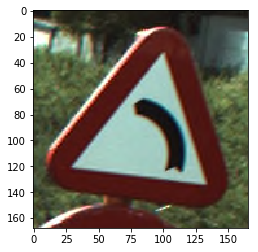

In [8]:
plt.imshow(images[1])
plt.show()

In [9]:
images_array = np.array(images)
labels_array = np.array(labels)
print(images_array.ndim, images_array.size)
print(labels_array.ndim, labels_array.size)

1 4575
2 283650


In [10]:
print(images_array.itemsize, images_array.nbytes)

8 36600


Manipulating the data

In [11]:
#rescaling
images28 = [transform.resize(image, (28,28)) for image in images]
#to array
images28 = np.array(images28)
#to grayscale
images28 = rgb2gray(images28)

/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
# Load the test data
test_images, test_labels = load_data(test_data_directory)

# Transform the images to 28 by 28 pixels
test_images28 = [transform.resize(image, (28, 28)) for image in test_images]
# to grayscale
test_images28 = rgb2gray(np.array(test_images28))
#to array
test_labels = np.asarray(test_labels)
test_labels = test_labels.reshape(-1,1)
#onehot encoding
test_labels = onehot.transform(test_labels)

# CNN with TensorFlow

In [13]:
def CNN(inputs):
    #Input layer 
    input_layer = tf.reshape(inputs, [-1,28,28,1]) #=>[batch_size, 28,28,1]
    
    #Conv layer 1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3,3],
        padding='same',
        activation=tf.nn.relu) #=>[batch_size, 28,28,32]
    #Pool layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2) #=>[batch_size, 14,14,32]
    
    #Conv layer 2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5,5],
        padding='same',
        activation=tf.nn.relu) #=>[batch_size, 14,14,64]
    #Pool layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2) #=>[batch_size,7,7,64] 
    
    #Reshape
    pool2_flat = tf.reshape(pool2, [-1,7*7*64]) #=>[batch_size, 3136]
    
    #Dense layer
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    #Logit layer
    logits = tf.layers.dense(inputs=dense, units=62)
    print(input_layer)
    print(conv1)
    print(pool1)
    print(conv2)
    print(pool2)
    print(pool2_flat)
    print(dense)
    print(logits)

    return(logits)
    
print('CNN ready')

CNN ready


In [14]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28,28])
y = tf.placeholder(tf.float32, [None, 62])
# Parameters
learning_rate   = 0.002
training_epochs = 20
batch_size      = 100
display_step    = 1
# Functions! 

_pred = CNN(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels=y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
_corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
init = tf.initialize_all_variables()

# Saver 
save_step = 1;
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 62), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Network Ready to Go!


In [15]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [16]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(4575/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = next_batch(batch_size, images28, labels)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: test_images28, y: test_labels})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

Epoch: 000/020 cost: 2.430858530
 Training accuracy: 0.740
 Test accuracy: 0.614
Epoch: 001/020 cost: 0.682139264
 Training accuracy: 0.940
 Test accuracy: 0.872
Epoch: 002/020 cost: 0.277663545
 Training accuracy: 0.960
 Test accuracy: 0.871
Epoch: 003/020 cost: 0.147322789
 Training accuracy: 0.960
 Test accuracy: 0.894
Epoch: 004/020 cost: 0.085500839
 Training accuracy: 0.970
 Test accuracy: 0.901
Epoch: 005/020 cost: 0.071956615
 Training accuracy: 0.990
 Test accuracy: 0.913


KeyboardInterrupt: 

In [ ]:
sess.close()